### Домашнее задание 6

1. Задание.
    - Для реализованной в методичке модели градиентного бустинга построить зависимости ошибки от количества деревьев при разных значениях шага градиента на одном графике и для разной глубины деревьев на другом. 
    - Сделать выводы о зависимости ошибки от этих гиперпараметров (шаг градиента, максимальная глубина деревьев, количество деревьев). 
    - Подобрать оптимальные значения этих гиперпараметров (минимум ошибки на тесте при отсутствии переобучения).


In [66]:
import matplotlib.pyplot as plt

from sklearn.datasets import load_diabetes
from sklearn.tree import DecisionTreeRegressor
from sklearn import model_selection

import numpy as np

In [67]:
X, y = load_diabetes(return_X_y=True)
X.shape, y.shape

((442, 10), (442,))

Разделим выборку на обучающую и тестовую в соотношении 75/25.

In [68]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25, random_state=42)

Напишем функцию, реализующую предсказание в градиентном бустинге.


$$a_{N}(x) = \sum^{N}_{n=1}\eta\gamma_{n}b_{n}(x).$$

In [69]:
def gb_predict(X, trees_list, coef_list, eta):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании 
    # прибавляются с шагом eta
    return np.array([sum([
        eta * coef * alg.predict([x])[0] for alg, coef in zip(trees_list, coef_list)]) 
                     for x in X])

В качестве функционала ошибки будем использовать среднеквадратичную ошибку. Реализуем соответствующую функцию.

In [70]:
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction) ** 2)) / len(y_real)

Используем $L_{2}$ loss $L(y, z) = (y-z)^{2},$ ее производная по $z$ примет вид $L'(y, z) = 2(z-y)$. Тогда сдвиг будет равен $s =- L'(y, z)$. 

In [71]:
def bias(y, z):
    return - 2 * (z - y)

Реализуем функцию обучения градиентного бустинга.

In [72]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    
    # eta - скорость обучения
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            z_train = gb_predict(X_train, trees, coefs, eta)
            
            # алгоритмы, начиная со второго, обучаем на сдвиг
            tree.fit(X_train, bias(y_train, z_train))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

In [232]:
def show_error_plot(depth_tree_set, val_name):
    plt.figure(figsize=(15, 10))
    plt.xlabel('Trees number')
    plt.ylabel('MSE')
    

    
    for i in range(len(depth_tree_set)):
        val = depth_tree_set[i][0]
        n_trees = len(depth_tree_set[i][1])
        train_err = depth_tree_set[i][2]
        test_err = depth_tree_set[i][3]
        
        min_train_error = float('inf')
        min_test_error = float('inf')
        min_diff = float('inf')
        trees_count = 0
        best_val = 0
        i = 0
        for tr_e, t_e in zip(train_err, test_err):
            #if tr_e < min_train_error and t_e < min_test_error:
            diff = abs(tr_e - t_e)
            if diff < min_diff:
                min_train_error = tr_e
                min_test_error = t_e
                    
                best_val = val
                trees_count = i
                min_diff = diff
            i+=1
        print(f"trees_count:{trees_count}, best_{val_name}:{best_val}")
        print(f"min_diff:{round(min_diff, 2)}, train_err:{round(min_train_error, 2)}, test_err:{round(min_test_error, 2)}")
        print()
            
        plt.xlim(0, n_trees)
        plt.plot(list(range(n_trees)), train_err, label=f'train error, {val_name} {val}')
        plt.plot(list(range(n_trees)), test_err, label=f'test error, {val_name} {val}')
    
    #print(f"best_trees:{best_trees}, best_{val_name}:{best_val}, min_diff:{min_diff}min_test_error:{min_test_error}")
    plt.legend(loc='upper right')
    plt.show()

In [127]:
def get_error_plot(n_trees, train_err, test_err):
    plt.xlabel('Iteration number')
    plt.ylabel('MSE')
    plt.xlim(0, n_trees)
    plt.plot(list(range(1, n_trees+1)), train_err, label='train error')
    plt.plot(list(range(1, n_trees+1)), test_err, label='test error')
    plt.legend(loc='upper right')
    plt.show()

In [128]:
def evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta):
    
    train_prediction = gb_predict(X_train, trees, coefs, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тренировочной выборке: {round(mean_squared_error(y_train, train_prediction))}')

    test_prediction = gb_predict(X_test, trees, coefs, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тестовой выборке: {round(mean_squared_error(y_test, test_prediction))}')

In [134]:
def test_depth(n_trees, n_depth, eta):
    coefs = [1] * n_trees
    depth_tree_list = []
    for depth in n_depth:
        trees, train_errors, test_errors = gb_fit(n_trees, depth, X_train, X_test, y_train, y_test, coefs, eta)
        depth_tree_list.append([depth, trees, train_errors, test_errors])
    show_error_plot(depth_tree_list, "depth")
    return depth_tree_list

In [135]:
def test_eta(n_trees, depth, eta):
    coefs = [1] * n_trees
    eta_tree_list = []
    for e in eta:
        trees, train_errors, test_errors = gb_fit(n_trees, depth, X_train, X_test, y_train, y_test, coefs, e)
        eta_tree_list.append([e, trees, train_errors, test_errors])
    show_error_plot(eta_tree_list, "eta")
    return eta_tree_list

#### Данные по разной глубине

trees_count:5, best_depth:4
min_diff:154.71, train_err:5829.84, test_err:5984.55

trees_count:4, best_depth:5
min_diff:263.15, train_err:7648.7, test_err:7911.85

trees_count:3, best_depth:6
min_diff:174.05, train_err:10731.83, test_err:10905.88

trees_count:3, best_depth:7
min_diff:498.28, train_err:10448.52, test_err:10946.8



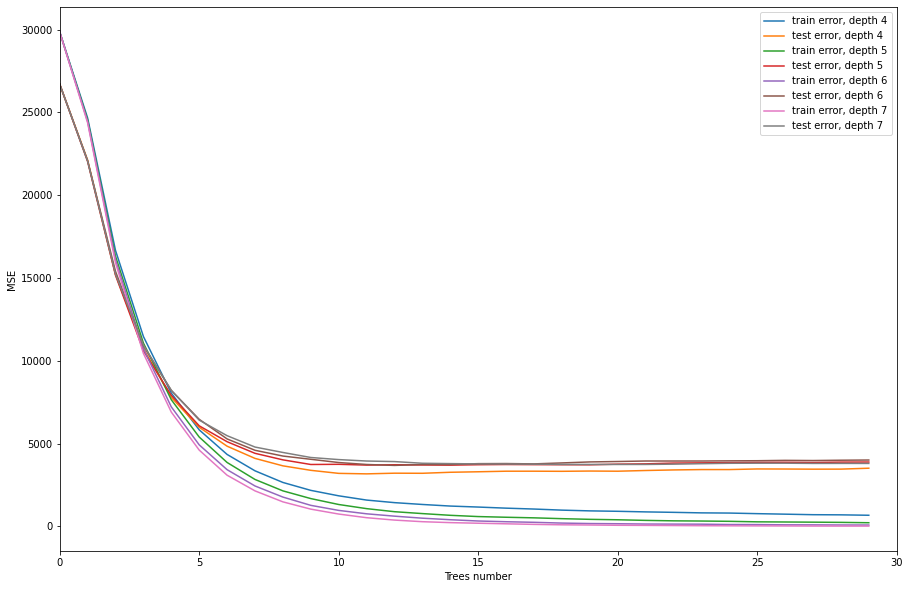

In [234]:
n_trees = 30
n_depth = np.arange(start=4, stop=8, step=1)
n_eta = 0.1

tree_list = test_depth(n_trees, n_depth, n_eta)

#### Лучшие параметры: 

trees_count:5, 

best_depth:4,

min_diff:154.71,

train_err:5829.84, 

test_err:5984.55

#### Данные по различным вариантам eta
Для лучшего подбота eta решил использовать лучше данные по глубине из предыдущего наблюдения

trees_count:29, best_eta:0.005
min_diff:1671.99, train_err:17883.11, test_err:16211.12

trees_count:8, best_eta:0.05
min_diff:104.44, train_err:7851.88, test_err:7747.43

trees_count:5, best_eta:0.1
min_diff:154.71, train_err:5829.84, test_err:5984.55

trees_count:1, best_eta:0.5
min_diff:510.27, train_err:9358.44, test_err:8848.17



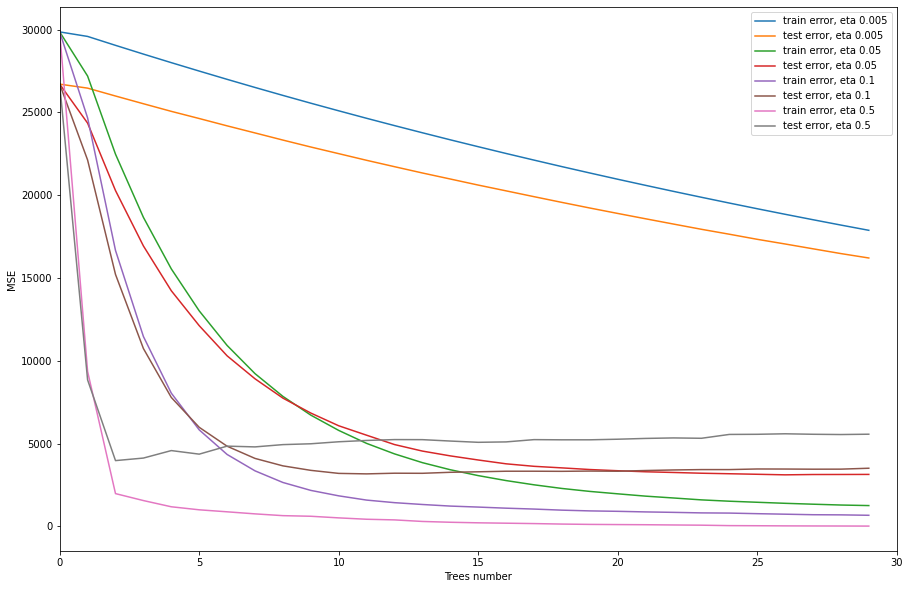

In [235]:
n_trees = 30
n_depth = 4
n_eta = [0.005, 0.05, 0.1, 0.5]

tree_list = test_eta(n_trees, n_depth, n_eta)

#### Лучшие параметры: 


trees_count:5, 

best_depth:4,

min_diff:154.71,

train_err:5829.84, 

test_err:5984.55

Финальная модель

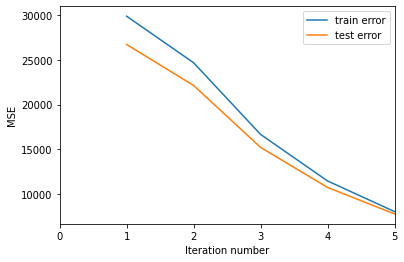

Ошибка алгоритма из 5 деревьев глубиной 4     с шагом 0.1 на тренировочной выборке: 5830
Ошибка алгоритма из 5 деревьев глубиной 4     с шагом 0.1 на тестовой выборке: 5985


In [236]:
n_trees = 5
coefs = [1] * n_trees
max_depth = 4
eta = 0.1

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)
get_error_plot(n_trees, train_errors, test_errors)
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)